In [ ]:
# Copyright (c) 2025 Advanced Micro Devices, Inc. All rights reserved This software is distributed under the MIT License, Contact: Alessandro Fanfarillo

In [1]:
import numpy as np
import random
import torch.nn.functional as F
import pandas as pd
import math
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from scipy.stats import anderson_ksamp, ks_2samp, gaussian_kde, mannwhitneyu, entropy
import seaborn as sns

torch.set_num_threads(16)

In [2]:
def simulate_max_temperature(month: int, day: int) -> float:
    # Check if the input is valid
    if month < 1 or month > 12:
        raise ValueError("Invalid month. Please enter a month between 1 and 12.")
    if day < 1 or day > 31:
        raise ValueError("Invalid day. Please enter a day between 1 and 31.")
    
    # Month and day pairs validation (e.g., February can't have 30 days)
    month_days = {
        1: 31, 2: 28, 3: 31, 4: 30, 5: 31, 6: 30,
        7: 31, 8: 31, 9: 30, 10: 31, 11: 30, 12: 31
    }
    
    if day > month_days[month]:
        raise ValueError(f"Invalid day for month {month}. {month} only has {month_days[month]} days.")

    # Simulate the day of the year
    days_in_year = 365
    day_of_year = sum(month_days[m] for m in range(1, month)) + day - 1
    
    # Simulate max temperature based on a sine wave for seasonal changes
    # Assuming the peak temperature in July and the lowest in January.
    max_temp = 60 + 40 * np.sin(2 * np.pi * (day_of_year / days_in_year - 0.2))
    
    # Add randomness for daily variation (e.g., between -10 and +10 degrees)
    random_variation = random.gauss(0, 5)
    
    max_temp = max_temp + random_variation
    
#    outlier_probability = 0.005
    
#    if random.random() < outlier_probability:
    # Generate an outlier: either extremely cold or extremely hot
#        if random.random() < 0.5:
            # Extremely cold outlier
#            max_temp += random.uniform(-20, -10)  # Below freezing outlier
#        else:
            # Extremely hot outlier
#            max_temp += random.uniform(10, 20)  # Unusually hot outlier
    
    return round(max_temp, 2)

In [3]:
# Example usage:
month = 7  # July
day = 15   # 15th day
temperature = simulate_max_temperature(month, day)
print(f"The simulated temperature in Denver on {month}/{day} is {temperature}°F.")

The simulated temperature in Denver on 7/15 is 85.99°F.


In [4]:
def generate_temperature_data(years: int = 10):
    month_days = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    max_temps = []
    month_day = []

    # Simulate data for each day over the specified number of years
    for year in range(years):
        for month in range(1, 13):
            for day in range(1, month_days[month - 1] + 1):
                temp = simulate_max_temperature(month, day)
                month_day_item = [month, day]
                max_temps.append(temp)
                month_day.append(month_day_item)
    
    max_temps_np = np.array(max_temps)
    month_day_np = np.array(month_day)
    
    return month_day_np, max_temps_np

# Generate 30 years of max temperature data
month_day_np, max_temps_np = generate_temperature_data(100)
print(month_day_np.shape, max_temps_np.shape)

(36500, 2) (36500,)


(100,)


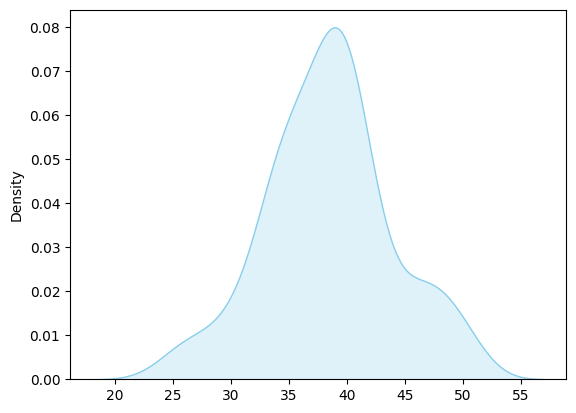

In [5]:
# Plot the distribution
feb_10_temp = max_temps_np[np.where((month_day_np[:,0]==2) & (month_day_np[:,1]==10))]
print(feb_10_temp.shape)
sns.kdeplot(feb_10_temp, fill=True, color="skyblue")
plt.show()

In [6]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
x = scaler_x.fit_transform(month_day_np)
y = scaler_y.fit_transform(max_temps_np.reshape(-1,1))

train_size = int(0.95 * len(x))
X_train, X_test = x[:train_size], x[train_size:]
Y_train, Y_test = y[:train_size], y[train_size:]

In [7]:
class CustomDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.from_numpy(X).float()
        self.Y = torch.from_numpy(Y).float()
        
    def __len__(self):
        return len(self.Y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

# Create datasets
train_dataset = CustomDataset(X_train, Y_train)
test_dataset = CustomDataset(X_test, Y_test)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

# Generative model Normalizing Flow: RealNVP

In [8]:
class ConditionalCouplingLayer(nn.Module):
    """
    A simple RealNVP-like coupling for 1D y, conditioned on c in R^2.
    y -> z = (y - t(c)) * exp(-s(c)).
    log_det_jac = -s(c).
    
    Inverse:
    z -> y = z * exp(s(c)) + t(c).
    """
    def __init__(self, c_dim=2, hidden_dim=32):
        super().__init__()
        # small MLP: c -> (log_scale, shift)
        self.net = nn.Sequential(
            nn.Linear(c_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 2)  # outputs [log_s, t] for 1D y
        )
    
    def forward(self, y, c):
        out = self.net(c)  # shape (B,2)
        log_s = out[:,0:1]  # (B,1)
        t = out[:,1:2]      # (B,1)
        
        z = (y - t) * torch.exp(-log_s)
        log_det = -log_s.squeeze(dim=1)  # (B,)
        return z, log_det
    
    def inverse(self, z, c):
        out = self.net(c)
        log_s = out[:,0:1]
        t = out[:,1:2]
        
        y = z * torch.exp(log_s) + t
        log_det = log_s.squeeze(dim=1)  # derivative wrt z
        return y, log_det


class RealNVP(nn.Module):
    def __init__(self, c_dim=2, n_flows=4, hidden_dim=32):
        super().__init__()
        self.n_flows = n_flows
        
        layers = []
        for _ in range(n_flows):
            layers.append(ConditionalCouplingLayer(c_dim, hidden_dim))
        self.layers = nn.ModuleList(layers)
    
    def forward_flow(self, y, c):
        log_det_sum = torch.zeros(y.size(0), device=y.device)
        z = y
        for layer in self.layers:
            z, log_det = layer(z, c)
            log_det_sum += log_det
        return z, log_det_sum
    
    def inverse_flow(self, z, c):
        log_det_sum = torch.zeros(z.size(0), device=z.device)
        y = z
        for layer in reversed(self.layers):
            y, log_det = layer.inverse(y, c)
            log_det_sum += log_det
        return y, log_det_sum

    def log_prob(self, y, c):
        # forward pass: y -> z
        z, log_det_sum = self.forward_flow(y, c)
        
        # log p(z) under N(0,1), in 1D
        # z is (B,1), so log p(z) = -0.5*(z^2 + log(2*pi))
        log_pz = -0.5*(z**2 + math.log(2*math.pi))
        log_pz = log_pz.sum(dim=1)  # sum over dims => 1D => just remove last dim
        
        return log_pz + log_det_sum
    
    def sample(self, c, n_samples=1):
        device = next(self.parameters()).device
        batch_size = c.size(0)
        
        c_rep = c.unsqueeze(1).expand(batch_size, n_samples, c.size(1))  # shape (B,n,2)
        c_rep = c_rep.reshape(batch_size*n_samples, c.size(1))          # (B*n,2)
        
        z = torch.randn(batch_size*n_samples, 1, device=device)
        y, _ = self.inverse_flow(z, c_rep)
        
        # reshape to (batch_size, n_samples, 1)
        y = y.view(batch_size, n_samples, 1)
        return y

In [9]:
def train_realnvp(dataset, num_epochs=300, batch_size=64, n_flows=4, hidden_dim=32, lr=1e-3):
    device = 'cpu'#torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Create dataset + loader
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    # Instantiate model + optimizer
    model = RealNVP(c_dim=2, n_flows=n_flows, hidden_dim=hidden_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(1, num_epochs+1):
        model.train()
        total_loss = 0.0
        
        for c_batch, y_batch in train_loader:
            c_batch = c_batch.to(device)
            y_batch = y_batch.to(device)
            # Negative log-likelihood
            # log_prob(y|c) => shape (batch_size,)
            logp = model.log_prob(y_batch, c_batch)
            loss = -logp.mean()  # we MINIMIZE negative log-likelihood
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item() * c_batch.size(0)
        
        avg_loss = total_loss / len(dataloader.dataset)
        if epoch % 50 == 0:
            print(f"Epoch {epoch}/{num_epochs}, NLL: {avg_loss:.4f}")
    
    return model

In [10]:
month_query = 2
day_query = 10
# Convert to float, matching how the dataset stores them
month_val = float(month_query)
day_val = float(day_query)

# 1) Train
model_flow = train_realnvp(dataset=train_dataset, num_epochs=400, batch_size=1024, n_flows=12, hidden_dim=64, lr=1e-5)

Epoch 50/400, NLL: -1.4439
Epoch 100/400, NLL: -1.6835
Epoch 150/400, NLL: -1.7112
Epoch 200/400, NLL: -1.7216
Epoch 250/400, NLL: -1.7251
Epoch 300/400, NLL: -1.7272
Epoch 350/400, NLL: -1.7285
Epoch 400/400, NLL: -1.7284


In [11]:
from sklearn.metrics import mean_squared_error

input_data = scaler_x.transform(np.array([[2., 10.]], dtype=np.float32))
c_test = torch.from_numpy(input_data).float()
# 2) Sample
model_flow.eval()
with torch.no_grad():
    #c_test = torch.tensor(input_data).to('cuda')  # batch_size=1, c=(0.5,0.5)
    c_test.to('cpu')
    y_samps = model_flow.sample(c_test, n_samples=100)
    y_samps.to('cpu')
    print("Samples for c=[2,10]:")
    y_pred = np.round(scaler_y.inverse_transform(y_samps.reshape(-1,1)),2)
    print(y_pred)
    print("Real Temperatures:", feb_10_temp)

Samples for c=[2,10]:
[[45.91]
 [37.56]
 [33.91]
 [37.97]
 [45.29]
 [38.86]
 [45.83]
 [39.55]
 [36.76]
 [47.99]
 [41.18]
 [49.63]
 [39.86]
 [39.65]
 [35.15]
 [39.59]
 [39.17]
 [38.  ]
 [38.83]
 [40.19]
 [33.99]
 [38.55]
 [35.36]
 [36.5 ]
 [38.13]
 [35.07]
 [39.13]
 [35.43]
 [37.71]
 [35.74]
 [42.43]
 [43.  ]
 [28.98]
 [31.55]
 [37.6 ]
 [41.93]
 [40.25]
 [31.56]
 [46.  ]
 [35.76]
 [41.26]
 [33.41]
 [29.26]
 [33.7 ]
 [39.82]
 [44.24]
 [40.47]
 [38.26]
 [39.74]
 [45.7 ]
 [29.99]
 [50.36]
 [43.99]
 [34.28]
 [34.87]
 [40.87]
 [31.62]
 [29.35]
 [40.35]
 [36.97]
 [25.9 ]
 [40.63]
 [37.36]
 [33.07]
 [30.77]
 [49.84]
 [43.54]
 [39.99]
 [41.3 ]
 [43.16]
 [34.82]
 [36.5 ]
 [43.51]
 [36.01]
 [42.92]
 [37.81]
 [48.29]
 [45.87]
 [32.29]
 [41.87]
 [36.88]
 [41.92]
 [38.22]
 [37.17]
 [37.15]
 [39.99]
 [45.74]
 [39.78]
 [35.44]
 [36.38]
 [49.24]
 [37.58]
 [31.15]
 [35.64]
 [39.19]
 [34.77]
 [35.79]
 [34.58]
 [45.05]
 [36.33]]
Real Temperatures: [36.98 39.25 40.72 30.9  35.99 31.24 39.07 33.73 30.52 33.

In [12]:
def compute_kl_divergence(y,y_hat):
    kde1 = gaussian_kde(y)
    kde2 = gaussian_kde(y_hat)

    # Choose a grid to evaluate each KDE
    data_min = min(y.min(), y_hat.min())
    data_max = max(y.max(), y_hat.max())

    # We'll generate a grid of 200 points between data_min and data_max.
    x_grid = np.linspace(data_min, data_max, 500)

    #Evaluate the KDEs on this grid
    p_density = kde1(x_grid)  # unnormalized density from arr1
    q_density = kde2(x_grid)  # unnormalized density from arr2

    # Convert densities to discrete probabilities
    # We'll treat each point in x_grid as a "bin center" and approximate bin width as the spacing.
    dx = x_grid[1] - x_grid[0]
    p_probs = p_density / np.sum(p_density)  # sum would be ~1/dx, but let's normalize anyway
    q_probs = q_density / np.sum(q_density)

    # Multiply by dx to turn densities into a proper discrete approximation of total=1.
    p_probs *= dx
    q_probs *= dx

    # Compute KL divergences
    kl_pq = entropy(p_probs, q_probs)
    kl_qp = entropy(q_probs, p_probs)

    print("\nKDE-based approximation")
    print("-----------------------")
    print(f"KL(p || q) = {kl_pq:.6f}")
    print(f"KL(q || p) = {kl_qp:.6f}")

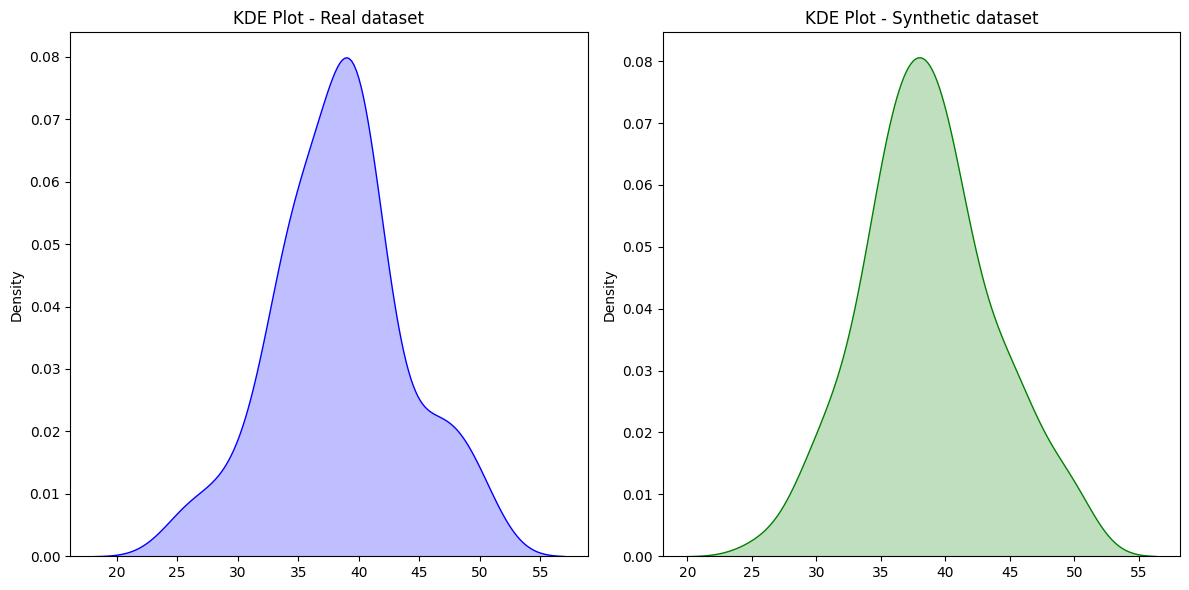

Real dataset mean and std: 38.41 5.38433524216314
Synthetic dataset mean and std: 38.675 4.995256249683294
KS Statistic: 0.07, P-value: 0.9684099261397212
Mann-Whitney U Statistic: 4913.0, P-value: 0.8326102981832896
Anderson-Darling Statistic: -0.9058356372299141, P-value: 0.25

KDE-based approximation
-----------------------
KL(p || q) = 0.009170
KL(q || p) = 0.008049
[36.98 39.25 40.72 30.9  35.99 31.24 39.07 33.73 30.52 33.88 29.01 33.28
 40.05 48.33 46.51 39.84 47.4  36.39 40.12 33.98 26.77 45.23 33.74 44.93
 49.2  39.38 34.82 48.21 50.08 36.78 40.4  26.31 40.14 40.62 47.31 34.82
 42.35 40.97 24.55 37.12 38.52 38.02 33.8  38.68 40.51 32.38 37.6  35.27
 37.92 39.21 33.13 40.61 34.44 44.03 38.04 46.95 40.68 33.96 35.23 36.05
 39.13 39.92 50.1  43.25 41.86 38.5  45.96 33.8  40.59 38.02 42.34 39.92
 36.48 34.11 38.45 40.77 35.16 30.76 43.71 34.82 26.5  37.12 39.07 36.71
 46.83 40.99 38.31 40.17 29.29 39.74 50.48 37.87 33.71 40.24 37.97 36.08
 41.95 34.44 39.68 40.25]
[45.91 37.56 33.9

/tmp/ipykernel_5709/2046741131.py:22: UserWarning: p-value capped: true value larger than 0.25. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  result = anderson_ksamp([feb_10_temp, y_pred])


In [13]:
# Compare the distribution
y_pred = y_pred[:,0]
#print("Expected Frequencies (under null hypothesis):")
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.kdeplot(feb_10_temp, ax=axes[0], fill=True, color="blue")
#sns.histplot(feb_10_temp, ax=axes[0], kde=False, edgecolor='black')
axes[0].set_title('KDE Plot - Real dataset')
sns.kdeplot(y_pred, ax=axes[1], fill=True, color="green")
#sns.histplot(y_pred, ax=axes[1], kde=False, edgecolor='green')
axes[1].set_title('KDE Plot - Synthetic dataset')
# Display the plots
plt.ylim(0, max(plt.gca().get_ylim()))
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

print("Real dataset mean and std:",np.mean(feb_10_temp),np.std(feb_10_temp))
print("Synthetic dataset mean and std:",np.mean(y_pred),np.std(y_pred))
stat, p_value = ks_2samp(feb_10_temp, y_pred)
print(f"KS Statistic: {stat}, P-value: {p_value}")
stat, p_value = mannwhitneyu(feb_10_temp, y_pred, alternative='two-sided')
print(f"Mann-Whitney U Statistic: {stat}, P-value: {p_value}")
result = anderson_ksamp([feb_10_temp, y_pred])
print(f"Anderson-Darling Statistic: {result.statistic}, P-value: {result.significance_level}")
compute_kl_divergence(feb_10_temp,y_pred)
print(feb_10_temp)
print(y_pred)